In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# CAM

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from constant import CSV_DIR, CLASS_NAMES
import numpy as np

from fastai.conv_learner import *
# import pixiedust
from matplotlib.patches import Rectangle
from datetime import datetime
import pandas as pd

import torch
import torchvision.transforms as transforms
from layers import *
from constant import CLASS_NAMES
from transform import chest_xray_transfrom
from metrics import *
import pretrainedmodels
from recorder import TrainingRecoder
import pretrainedmodels
from dataset import ChestXray14Dataset
from model_data import ModelData
from chexnet import ChexNet
import cv2


In [3]:
PATH = Path('/home/dattran/data/xray-thesis/chestX-ray14')
IMAGE_DN = 'images'
attention_dn = PATH/'tmp/attention'
attention_dn.mkdir(parents=True, exist_ok=True)

image_name = '00000001_000.png'
sz = 224

image_file = PATH/IMAGE_DN/image_name
chexnet = ChexNet(model_name='20180429-130928')

In [4]:
from constant import IMAGENET_MEAN, IMAGENET_STD
from heatmap import HeatmapGenerator

tfm = transforms.Compose([ 
                        transforms.Resize(224),
                        transforms.ToTensor(),
                        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
                        ])

`g = HeatmapGenerator(chexnet, mode='cam')

In [5]:
imgs = []
for i in range(10):
    image = Image.open(image_file).convert('RGB')
    imgs.append(tfm(image))
imgs = torch.stack(imgs)
heatmaps, diseases = g.generate(imgs)
heatmap = to_np(heatmaps[0])

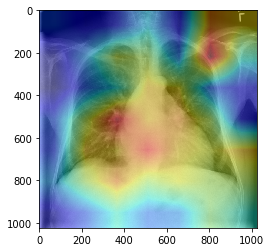

In [6]:
plt.imshow(image)
plt.imshow(cv2.resize(heatmap, image.size), alpha=0.4, cmap='jet')

# Attention

In [7]:
from scipy import ndimage
from matplotlib.patches import Rectangle
theta = 0.7

def plot_attention(image, heatmap, ax=None):
    """
    image (1024, 1024, 3)
    heatmap (7, 7)
    """
    if ax == None: ax = plt.subplot()
    heatmap = to_np(heatmap)
    heatmap = cv2.resize(heatmap, (1024, 1024))
    
    mask = heatmap > theta
    slice_y, slice_x = ndimage.find_objects(mask, True)[0]
    xy = (slice_x.start, slice_y.start)
    height = slice_y.stop - slice_y.start
    width= slice_x.stop - slice_x.start
    
    ax.imshow(image)
    ax.imshow(heatmap, alpha=0.4, cmap='jet')
    rect = Rectangle(xy, width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    

In [8]:
g = HeatmapGenerator(chexnet)

In [9]:
image = Image.open(image_file).convert('RGB')
heatmaps, diseases = g.generate(tfm(image)[None])

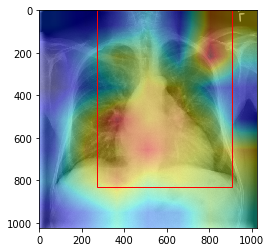

In [10]:
plot_attention(image, heatmaps[0])